In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import astropy.constants as const
import astropy.units as un
from astropy.visualization import quantity_support
import scipy as sp
from scipy.special import kv

In [2]:
#creating the grid x = r/r_lc
N_position = 500
x1 = 1.01
x2 = 5.

X = np.linspace(x1, x2, N_position)*un.dimensionless_unscaled

X_reversed = X[::-1] #reversed matrix for the electron integration



In [3]:
# Values and units of physical constants and other quantities and parameters that are used through the code

e = const.e.esu       #Electron charge
m_e = const.m_e.cgs   #Electron mass
c = const.c.cgs       #Speed of light
h = const.h.cgs       #Planck's constant

r_surface = 10**6 * un.cm  #Surface of the NS
B_surface = 10**13 * un.G  #Magnetic field at the surface of the NS
Period = 0.033 * un.s      #Period of rotation

r_lc = c*Period/(2*np.pi)  #Light cylinder radius
B_lc = B_surface*r_surface**3/r_lc**3   #Magnetic field at the light cylinder

R_curv = X**2*r_lc   #Radius of curvature of the particle trajectories, calculated analyticaly

#Value of Lorentz factor when the radiation reaction limit is reached
# gamma_rrl = 4*10**7*(B_surface/(10**13*un.G))**(1/4)*(Period/(1*un.s))**(-1/4)   
gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)

k = 2.   #Pair multiplicity

In [4]:
#Define the equation that gives the evolution of the Lorentz factor Γ
def eq_of_motion(gamma, X, k, charge_sign):
    
    '''The evolution of the Lorentz factor as given in Contopoulos, Petri, Stefanou, eq. 27 (corrected)'''

    #   Term of numerical constants
    num_term = r_lc*e*B_lc/(m_e*c**2)

    #   Term that depends on the multiplicity k
    k_term = 3/(5*k)*(1-1/(5*k))

    #   Lorentz factor at the radiation reaction limit
    gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)  

    
    dgdx = charge_sign*num_term*(k_term*(X**2 - 1)**(-0.3)*X**(-2.4) - (gamma**4/gamma_rrl**4)*X**(-3)*(X**2 - 1)**(-0.5))
    
    return dgdx


In [5]:
#Integrate the equation

gamma_0 = 1.   #initial value of Γ

gamma_positron = odeint(eq_of_motion, gamma_0, X, args = (k, +1))        #for positrons
gamma_positron = gamma_positron.reshape(N_position,)*un.dimensionless_unscaled  #reshape the matrix to a convenient form

gamma_electron = odeint(eq_of_motion, gamma_0, X_reversed, args = (k, -1))  #for electrons
gamma_electron = gamma_electron.reshape(N_position,)*un.dimensionless_unscaled     #reshape the matrix to a convenient form

<IPython.core.display.Javascript object>


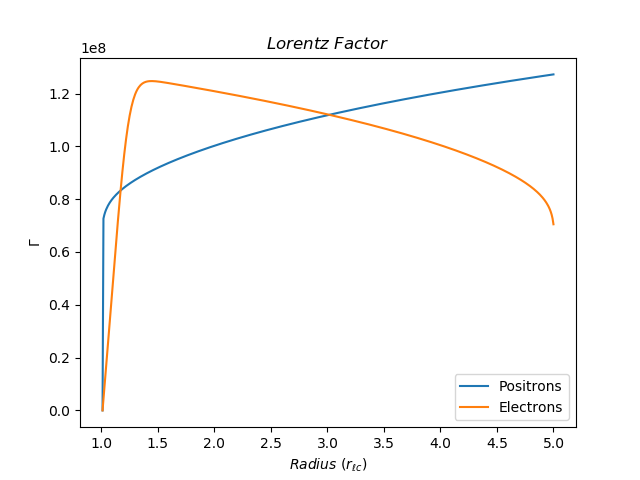

In [12]:
#Plot the evolution of Γ
%matplotlib notebook

# quantity_support()

plt.plot(X, gamma_positron, label = 'Positrons')
plt.plot(X, gamma_electron, label = 'Electrons')
plt.xlabel('$Radius \ (r_{\ell c})$')
plt.ylabel('$\Gamma$')
plt.title('$Lorentz \ Factor$')
plt.legend()
# plt.savefig('ECS_gamma_k2_test.png')

In [7]:
#Define the curvature radiation spectrum of one particle with given R_c and Γ

def power_spectrum(nu, nu_crit, R_curv, gamma):
     
    '''Takes a range of frequencies, the critical frequency of the emission, the 
        radius of curvature and the Lorentz factor as input and returns the 
        instantaneous radiated spectrum of one particle.
    '''
    
    integral = sp.integrate.quad(lambda z: kv(5./3., z), nu/nu_crit, +np.inf)[0]*un.dimensionless_unscaled
    
    power = np.sqrt(3)*e**2/(2*np.pi)*gamma/R_curv*nu/nu_crit*integral
    
    return power


In [8]:
#Calculate the spectrum of the particles


#Frequency grid
N_frequency = 100        #Number of frequencies in which the spectrum is calculated
f1 = 20                  #Minimum 
f2 = 30                  #Maximum 
frequency = np.logspace(f1, f2, N_frequency)*un.Hz       #Frequencies distributed evenly in a logarithmic space
photon_energy = (frequency*h).to(un.eV)                  #Corresponding energy in eV


#Critical frequency for curvature radition
nu_crit_positron = 3*c/2*gamma_positron**3/R_curv        
nu_crit_electron = 3*c/2*gamma_electron**3/R_curv        

#initializing the matrix of the instantaneous spectrum
j_curv_positron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)     
j_curv_electron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)

#Total radiated spectrum along the trajectory
total_power_positron = np.zeros((N_frequency))*j_curv_positron.unit
total_power_electron = np.zeros((N_frequency))*j_curv_electron.unit

#Spectrum calculation
for nu in range(N_frequency-1):
    for i in range(N_position-1):
        j_curv_positron[nu][i] = power_spectrum(frequency[nu], nu_crit_positron[i], R_curv[i], gamma_positron[i])
        total_power_positron[nu] += j_curv_positron[nu][i]
        
        j_curv_electron[nu][i] = power_spectrum(frequency[nu], nu_crit_electron[i], R_curv[i], gamma_electron[i])
        total_power_electron[nu] += j_curv_electron[nu][i]

/home/petros/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/petros/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


In [9]:
index_max_el = (photon_energy*total_power_electron).argmax()
index_max_pos = total_power_positron.argmax()
print(index_max_el)

63


<IPython.core.display.Javascript object>


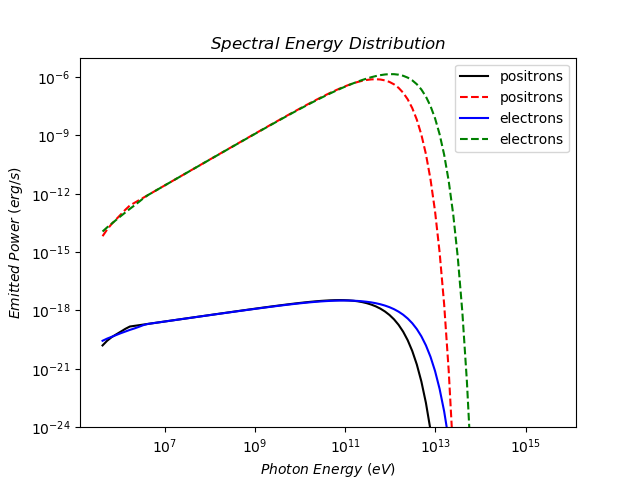

In [13]:
# Spectrum plots
%matplotlib notebook
plt.plot(photon_energy, total_power_positron, color = 'k', label = 'positrons')
plt.plot(photon_energy, photon_energy*total_power_positron, color = 'r', ls = '--', label = 'positrons')
# plt.axvline(photon_energy[index_max_el])

plt.plot(photon_energy, total_power_electron, color = 'b', label = 'electrons')
plt.plot(photon_energy, photon_energy*total_power_electron, color = 'g', ls = '--', label = 'electrons')


# for i in range(N_position):
#     plt.plot(photon_energy, j_curv[:, i])
    

plt.xscale('log')
plt.yscale('log')
plt.ylim([10**(-24),10**(-5)])
# plt.xlim([10**(7),10**(13)])
plt.xlabel('$Photon \ Energy \ (eV)$')
plt.ylabel('$Emitted \ Power \ (erg/s)$')
plt.title('$Spectral \ Energy \ Distribution$')
plt.legend()
# plt.savefig('ECS_spectrum_k2_test.png')